In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import yfinance
import talib as ta
style.use("ggplot")

#### Get the IBM OHLCV Data from yfinance

In [2]:
data = yfinance.download("IBM", start="2000-01-01", interval="1d")
# we'll get rid of datetime index simnce we won't be using dates as features
# and non-trading days would lead to messier plots
data.index = range(len(data))
# we'll remove the adjusted closing price since it is messy for the earlier data 
data.pop("Adj Close")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
0,107.492828,110.898659,106.955070,110.898659,10823694
1,108.986618,109.464630,105.999046,107.134323,8606279
2,107.970840,114.483749,107.194077,110.898659,13318927
3,112.810707,113.706978,108.508606,108.986618,8338607
4,112.093689,112.750954,105.760040,108.508606,12402108
...,...,...,...,...,...
5754,142.630005,146.080002,142.179993,144.199997,5293500
5755,144.080002,146.160004,142.000000,144.339996,4727100
5756,144.130005,144.949997,144.009995,144.520004,3445200
5757,143.410004,146.179993,143.250000,146.089996,3954000


### Plotting and Checking for Missing Values

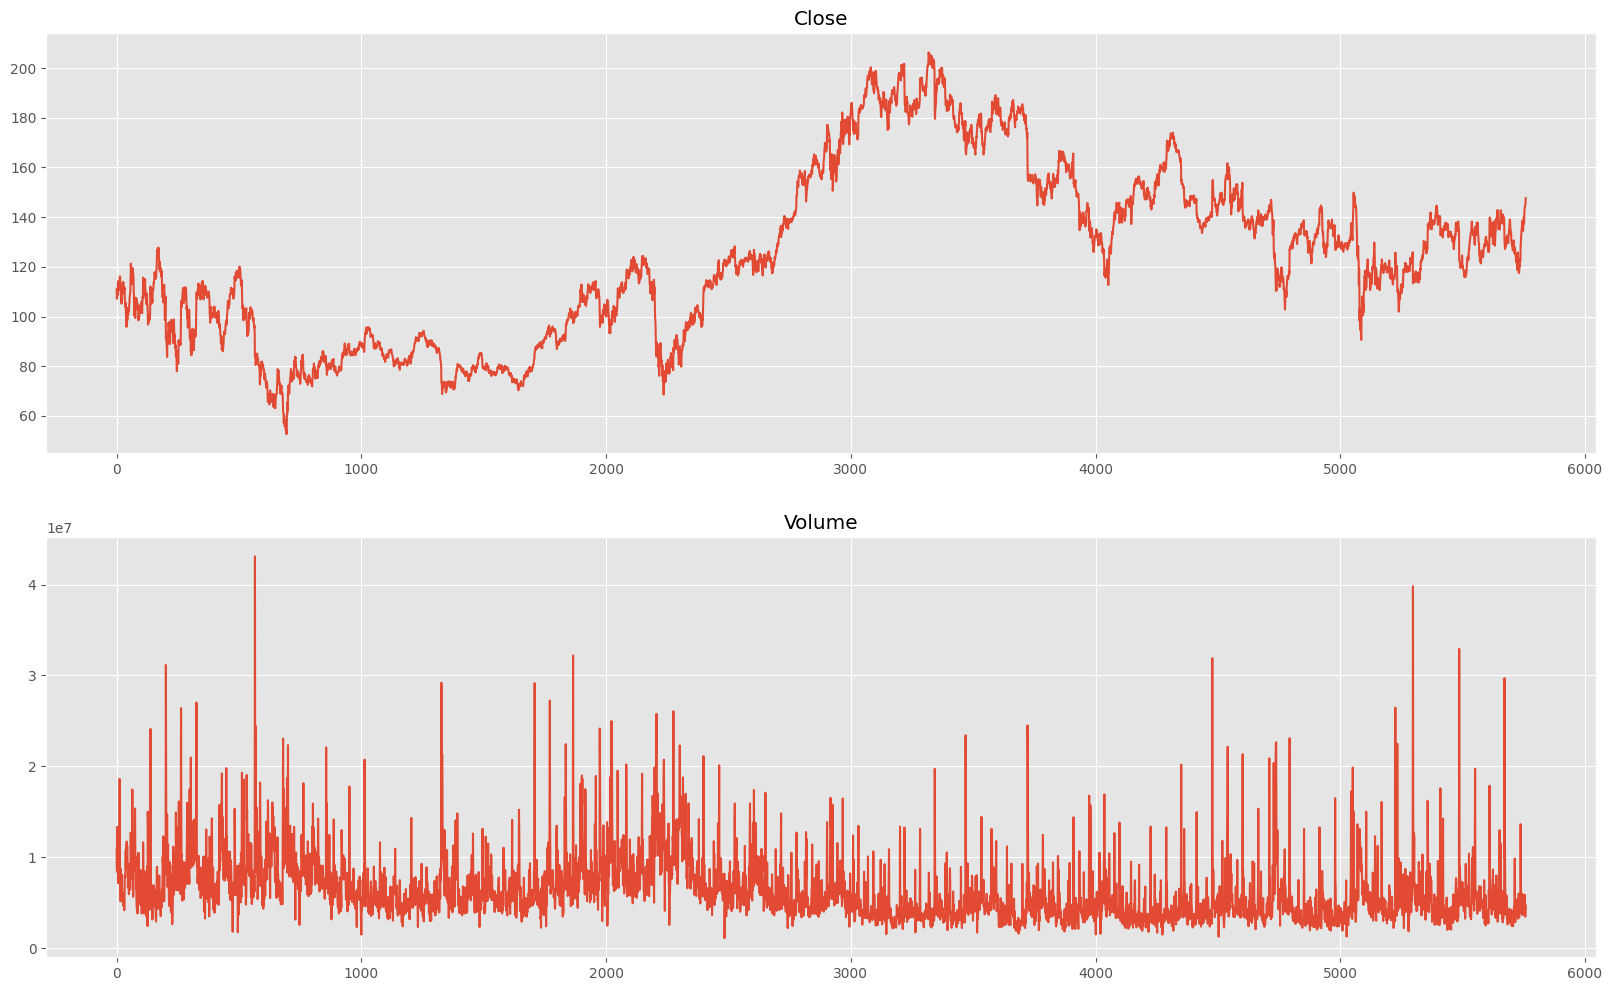

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(20,12))
ax1, ax2 = axes

ax1.plot(range(len(data)), data["Close"])
ax1.set_title("Close")

ax2.plot(range(len(data)), data["Volume"])
ax2.set_title("Volume")

plt.show()

In [4]:
data[data["Volume"] == 0]

,Open,High,Low,Close,Volume


In [5]:
data.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,5759.0,1.240941e+02,3.451339e+01,5.224665e+01,9.384799e+01,1.218000e+02,1.471606e+02,2.059082e+02
High,5759.0,1.252274e+02,3.456766e+01,5.420650e+01,9.498088e+01,1.227438e+02,1.479780e+02,2.064053e+02
Low,5759.0,1.230449e+02,3.445857e+01,5.163480e+01,9.286329e+01,1.208795e+02,1.461520e+02,2.048757e+02
Close,5759.0,1.241523e+02,3.452057e+01,5.264819e+01,9.397706e+01,1.219120e+02,1.470698e+02,2.063098e+02
Volume,5759.0,6.283100e+06,3.454429e+06,1.074765e+06,4.001578e+06,5.417025e+06,7.560017e+06,4.310284e+07


### Feature Engineering

##### We will provide a smoothed version of closing price and daily returns data as additional features to the models
##### Also, we attempt to "de-noise" volume data by smoothing its log values without losing too much signal.

###### RSI: https://www.investopedia.com/terms/r/rsi.asp
###### MACD: https://www.investopedia.com/terms/m/macd.asp
###### CCI: https://www.investopedia.com/terms/c/commoditychannelindex.asp

In [7]:
data["20 Day SMA"] = data["Close"].rolling(20).mean()
data["Mean Daily Returns"] = (data["Close"]/data["Close"].shift(1) - 1).rolling(20).mean()
data["Mean Log Volume"] = np.log(data["Volume"]).rolling(20).mean()

data["RSI"] = ta.RSI(data["Close"], 14)
data["MACD"] = ta.MACD(data["Close"], 13, 26, 9)[0]
data["CCI"] = ta.CCI(data["High"], data["Low"], data["Close"], 14)

data = data.dropna()
data.index = range(len(data))

data

,Open,High,Low,Close,Volume,20 Day SMA,Mean Daily Returns,Mean Log Volume,RSI,MACD,CCI
0,110.181641,110.838913,106.596558,107.552582,8026376,110.608867,-0.003614,15.629914,44.267472,-0.385340,-103.402257
1,107.074570,108.448853,103.967499,106.118546,8006921,110.106955,-0.004281,15.638097,42.053913,-0.673441,-201.879516
2,105.640533,105.640533,103.728493,103.967499,7777324,109.611018,-0.004317,15.641566,38.910861,-1.042922,-213.922932
3,104.027245,106.118546,103.429733,105.640533,9531152,109.312261,-0.002515,15.672634,42.509833,-1.210049,-141.600744
4,105.043022,105.043022,100.322655,103.250481,10786561,109.049355,-0.002255,15.683339,38.977097,-1.494279,-151.793647
...,...,...,...,...,...,...,...,...,...,...,...
5721,142.630005,146.080002,142.179993,144.199997,5293500,135.333998,0.008713,15.489007,70.874403,3.869833,194.869816
5722,144.080002,146.160004,142.000000,144.339996,4727100,136.403998,0.008178,15.485012,71.042733,4.004362,146.795982
5723,144.130005,144.949997,144.009995,144.520004,3445200,137.504498,0.008415,15.458058,71.272630,4.081139,125.375778
5724,143.410004,146.179993,143.250000,146.089996,3954000,138.393998,0.006595,15.396206,73.266177,4.206875,116.100187


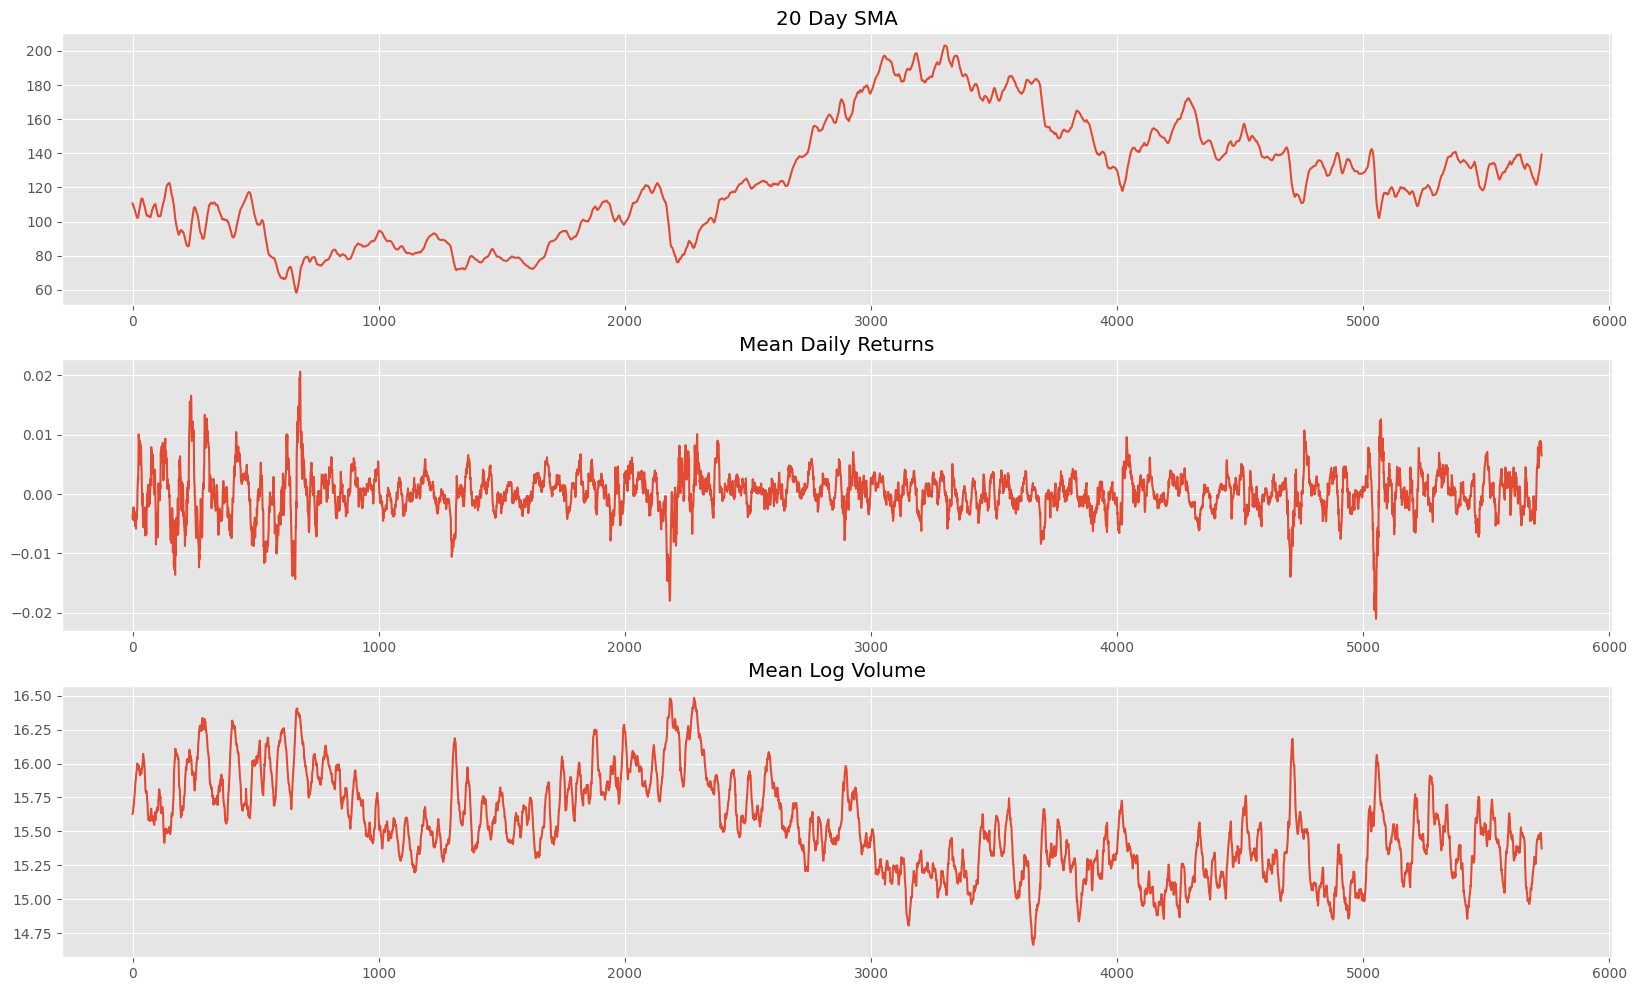

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(20,12))
ax1, ax2, ax3 = axes

ax1.plot(range(len(data)), data["20 Day SMA"])
ax1.set_title("20 Day SMA")

ax2.plot(range(len(data)), data["Mean Daily Returns"])
ax2.set_title("Mean Daily Returns")

ax3.plot(range(len(data)), data["Mean Log Volume"])
ax3.set_title("Mean Log Volume")

plt.show()

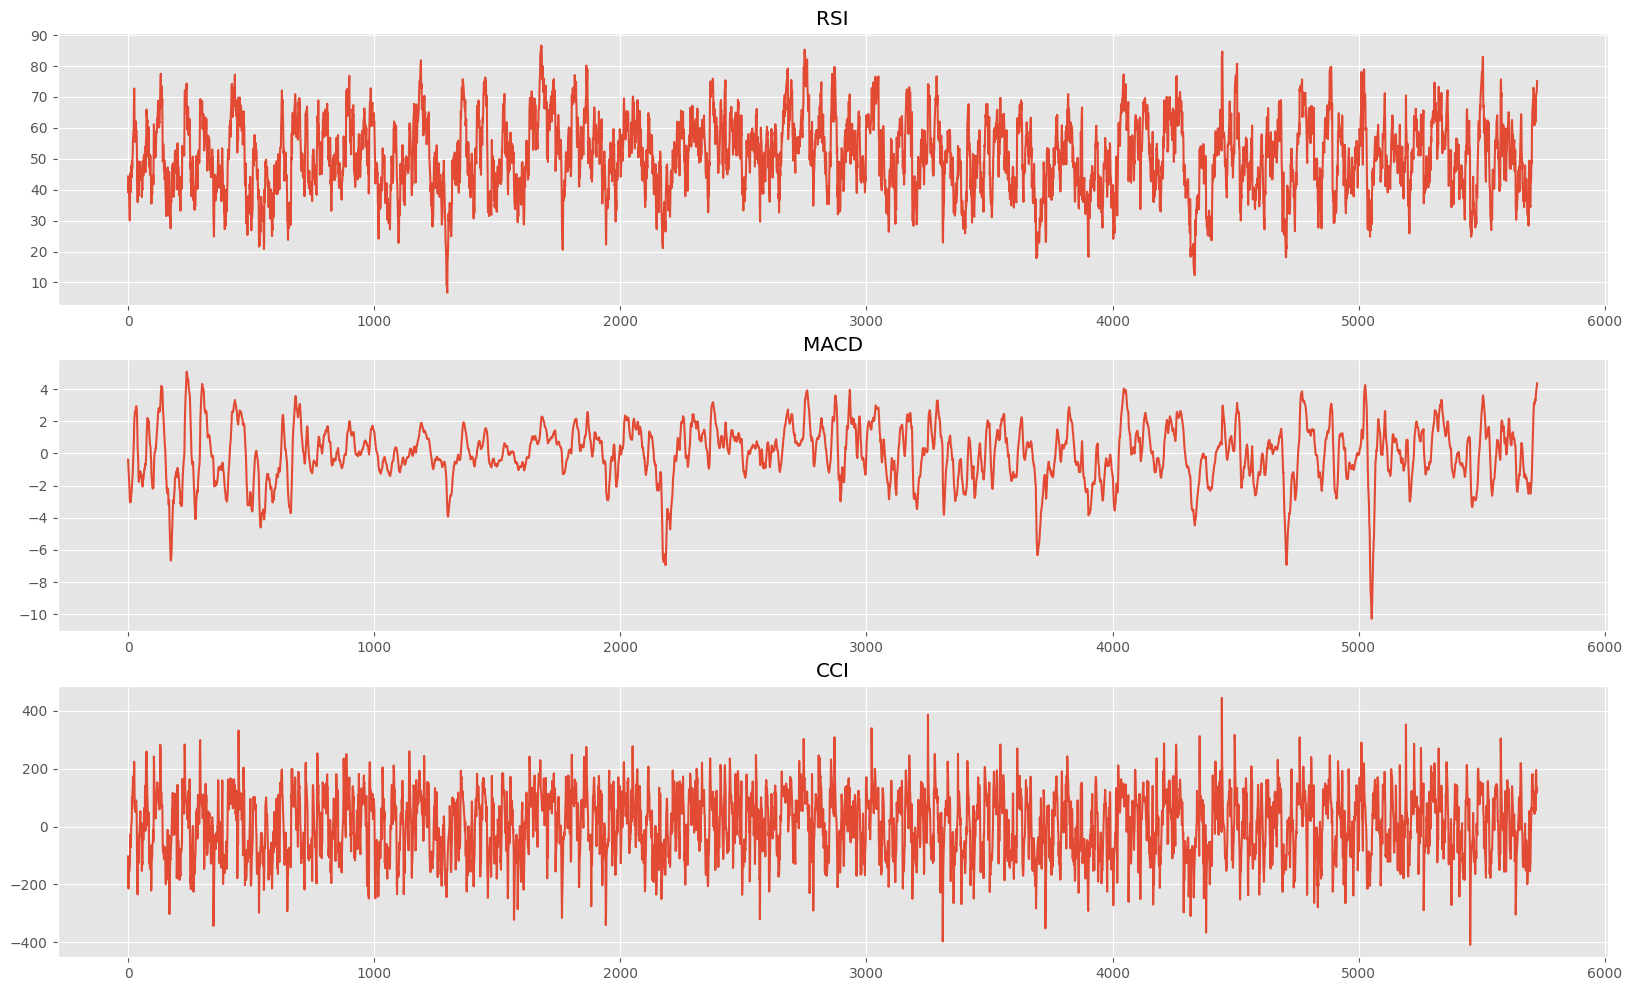

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(20,12))
ax1, ax2, ax3 = axes

ax1.plot(range(len(data)), data["RSI"])
ax1.set_title("RSI")

ax2.plot(range(len(data)), data["MACD"])
ax2.set_title("MACD")

ax3.plot(range(len(data)), data["CCI"])
ax3.set_title("CCI")

plt.show()

In [10]:
data.to_csv("Storage/Data.csv")